<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span><ul class="toc-item"><li><span><a href="#Иследование-качества-модели-без-преобразования" data-toc-modified-id="Иследование-качества-модели-без-преобразования-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Иследование качества модели без преобразования</a></span></li><li><span><a href="#Иследование-качества-модели-c-преобразованием" data-toc-modified-id="Иследование-качества-модели-c-преобразованием-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Иследование качества модели c преобразованием</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

## Загрузка данных

In [ ]:
data = pd.read_csv('/datasets/insurance.csv')
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


5 столбцов, пол, возраст, зарплата, количество членов семьи и страховые выплаты. Колонки названы на русский лад, что не комильфо, также странно задан пол и страховые выплаты, логичнее было их сделать логическими переменными, наверное, но посмотрим дальше.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Нет пропусков, хорошее начало! Но думаю, что можно все привести к инту, для какого то посредственного удобства, по всей видимости зарплаты и возраст указаны в целых числах.

In [ ]:
data[['Зарплата', 'Возраст']] = data[['Зарплата', 'Возраст']].astype('int')

In [ ]:
data.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.359400,1.194200,0.148000
std,0.500049,8.440807,9900.082063,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Судя по дескрайбу количество мужчин и женщин стремиться к паритету

Получить страховые выплаты 5 раз это надо постараться, или быть слишком невезучим, или же ошибка в данных.

Проверим на дубликаты:

In [ ]:
data.duplicated().sum()

153

Дубликаты смысла для обучения точно не несут, убить, нельзя помиловать.

In [ ]:
data = data.drop_duplicates()

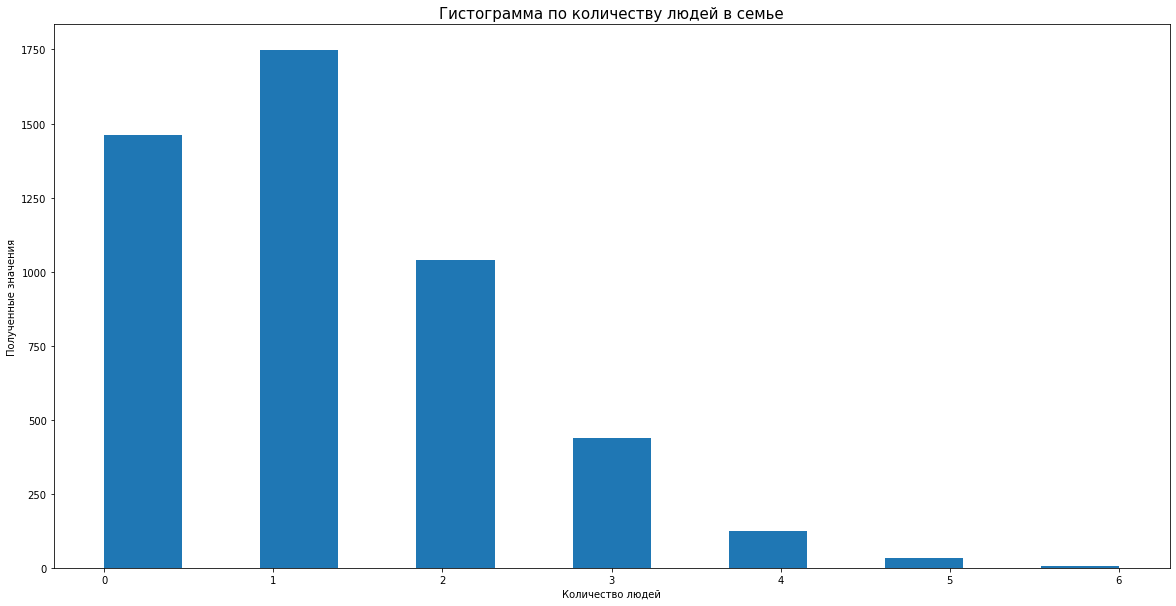

In [ ]:
plt.figure(figsize=[20,10])
plt.hist(data['Члены семьи'], bins=13)
plt.xlabel('Количество людей')
plt.ylabel('Полученные значения')
plt.title('Гистограмма по количеству людей в семье', fontsize=15)
plt.show()

Вообще странная графа членов семьи, ведь если ты даже один, то твоя семья - это ты 1, тут вероятно идет речь о детях. Вообще круговая диаграмма была бы гораздо нагляднее, но я потерял час в поисках адекватной реализации, по итогу получил какое-то око саурона, не отрыл я реализации по одной серии, обычно идет круговая по 2 сериям, где первой задается категория, а вторая какая-то количественная (и я пытался станцевать с бубном, но как-то не дотанцевал), поэтому если у тебя где-то под рукой смачный шаблончик для адекватной круговой диаграммы, дай пожалуйста кусь (хотя думаю что на второй час потуг я бы его нашел, точно он где-то лежит на просторах интернета, но время поджимает)! Вообще грустно, что за 7 проектов, я как-то гистограммами всегда малой кровью отделывался. В данном же случае гистограммы-столбчатой диаграммы все равно приходится головой думать, что примерно каждый третий бездентый, а самая популярная группа - с одним ребенком!

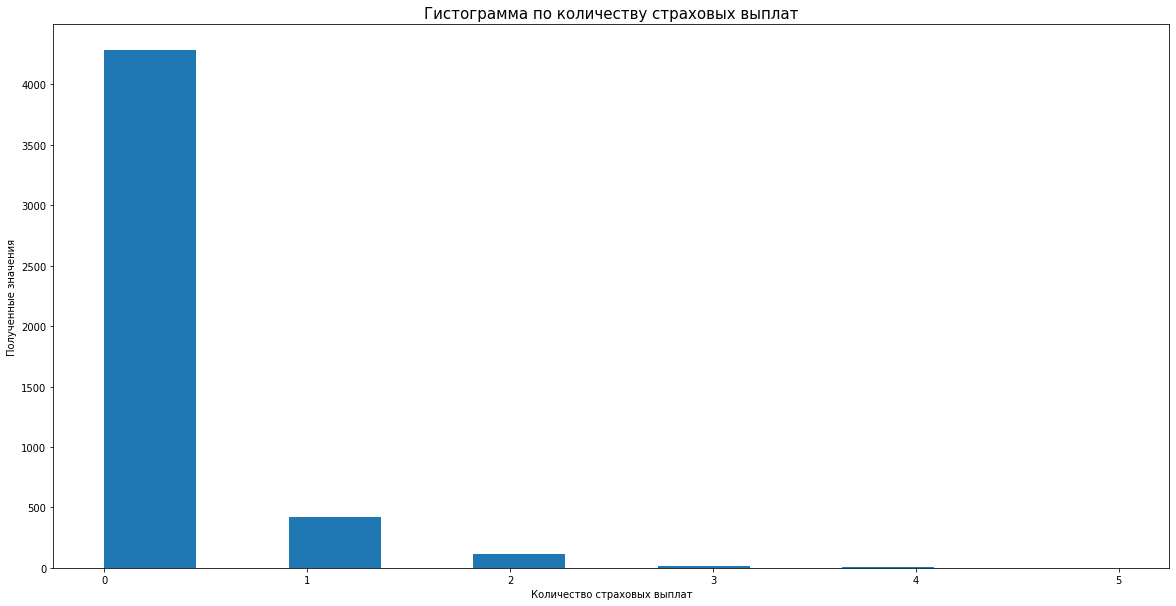

In [ ]:
plt.figure(figsize=[20,10])
plt.hist(data['Страховые выплаты'], bins=11)
plt.xlabel('Количество страховых выплат')
plt.ylabel('Полученные значения')
plt.title('Гистограмма по количеству страховых выплат', fontsize=15)
plt.show()

Выглядит так, как будто страховой бизнесс один из самых прибыльных в мире, поскольку платить придется примерно лишь каждому 9-10, однако обычно сумма компенсации колоссальна!

## Умножение матриц

В этом задании вы можете записывать формулы в *Jupyter Notebook.*

Чтобы записать формулу внутри текста, окружите её символами доллара \\$; если снаружи —  двойными символами \\$\\$. Эти формулы записываются на языке вёрстки *LaTeX.*

Для примера мы записали формулы линейной регрессии. Можете их скопировать и отредактировать, чтобы решить задачу.

Работать в *LaTeX* необязательно.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Необходимо доказать, что $ a = a '$

Зададим новую матрицу признаков как произведение старой X на обратимую,

$$X' = X∗P$$

Подставим новое значение $X'$ в формулу $w'$,

$$w'=((XP)^TXP)^{−1}(XP)^Ty$$

Раскроем первое произведение $(XP)^T$,

$$w'=(P^TX^TXP)^{-1}P^TX^Ty$$

Перегруппируем множители в скобках, чтобы это выглядело как произведение трех множителей,

$$w'=(P^T(X^TX)P)^{-1}P^TX^Ty$$

Раскроем скобки $(P^T(X^TX)P)^{-1}$,
   
$$w'=P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty$$

Так как $P$ по условию обратимая, то произведение  $(P^T)^{−1}P^T$ равно $E$(единичная матрица),
    
$$w'=P^{-1}(X^TX)^{-1}EX^Ty=P^{-1}(X^TX)^{-1}X^Ty$$

Можно заметить, что справа получилась формула для $w$,

$$w'=P^{-1}(X^TX)^{-1}X^Ty=P^{-1}w$$

Подставим новое значение весов $ 𝑤' $ в формулу для предсказаний линейной регрессии. Предсказания модели расчитываются по формуле,
    
$$a=Xw$$


Подставим в эту формулу значения $X'$ и $w'$ для того, чтобы на их основе вычислить предсказания модели $a'$,
    
$$a'=X'w'=XPP^{-1}w$$

Так как $P$ по условию обратимая, то произведение $PP^{−1}$ снова равно $E$,

$$a'=XPP^{-1}w=XEw=Xw=a$$

Мы доказали, что предсказания $a'$ для матрицы признаков, умноженных на обратимую матрицу $P$ равны предсказаниям $a$. Следовательно, отвечая на вопрос изменится ли качество линейной регрессии при умножении признаков на обратимую матрицу - нет, не изменится.

**Ответ:** Не изменится.  В данном случае, параметры линейной регрессии в исходной задаче $w$ и в преобразованной $w'$ связаны следующим образом,

$$w'=P^{-1}w$$

**Обоснование:** Описано выше.

**Вывод:** не быть мне математиком, потому что я бы никогда не додумался до такого вывода без доступных на гитхабе проектов и комментариев с пачки:CCCCCCCCCCCC

## Алгоритм преобразования

**Алгоритм**

Для защиты будем умножать матрицу признаков на обратимую матрицу, сгенерированную случайно. Нам нужно:
- сгенерировать обратимую матрицу, размерностью соответствующую количеству столбцов признаков.
- умножить матрицу исходных признаков на полученную сгенерированную матрицу.
- посчитать качество модели (метрик R2 и MSE) на полученной матрице и сравнить с качеством модели на матрице исходных данных.

**Обоснование**

В предыдущем пункте мы выяснили, что предсказания на измененной и изначальной матрице не должны отличаться, поэтому результаты метрик R2 и MSE должны оказаться равны. Тем самым мы докажем, что правильно защитили наши данные без вреда для предсказаний.

## Проверка алгоритма

### Иследование качества модели без преобразования

In [ ]:
mse = [] # список под результаты метрики mse
r2 = [] # список под результаты метрики r2
features = data.drop('Страховые выплаты',axis=1) # выделим признаки для обучения
target = data['Страховые выплаты']
features_train, features_test, target_train, target_test = train_test_split( features, target, test_size=0.25, random_state=42) # создаем выборки
model = LinearRegression() # создаем модель
model.fit(features_train, target_train) # обучаем модель
mse.append(mean_squared_error(model.predict(features_test), target_test))
r2.append(r2_score(target_test, model.predict(features_test)))
print("R2 =", r2[-1])
print("MSE =", mse[-1])

Непонятно, есть ли большая необходимость масштабировать, так как в требованиях к проекту этого нет, но полученные данные содержат признаки разных размеров и масштабов. Различные масштабы данных отрицательно влияют на результат прогнозов с точки зрения ошибок классификации и показателей точности. Таким образом, перед моделированием желательно и необходимо масштабировать данные.

In [ ]:
regressor = LinearRegression() # создаем модель
scaller = StandardScaler() # создаем объект функции стандартизации
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)]) # как перевел scikit-learn.org - задаем "конвеер преобразований", с которым далее будем работать с масштабированными уже признаками
pipeline.fit(features_train, target_train) # обучаем модель
mse.append(mean_squared_error(model.predict(features_test), target_test))
r2.append(r2_score(target_test, pipeline.predict(features_test)))
print("R2 =", r2[-1])
print("MSE =", mse[-1])

Видим что качество модели меняется абсолютно несущественно.

### Иследование качества модели c преобразованием

In [ ]:
# Задаем случайную матрицу
n = features.shape[1]
matrix = np.random.randint(1,42, (n,n))
matrix_features = features
matrix_transformation = matrix_features @ matrix
np.linalg.inv(matrix)

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(matrix_transformation, target, test_size=0.25, random_state=42) # разбиваем на выборки
model = LinearRegression() # создаем модель
model.fit(features_train, target_train) # обучаем модель
mse.append(mean_squared_error(model.predict(features_test), target_test))
r2.append(r2_score(target_test, model.predict(features_test)))
print("R2 =", r2[-1])
print("MSE =", mse[-1])

In [ ]:
regressor = LinearRegression() # создаем модель
scaller = StandardScaler() # создаем объект функции стандартизации
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)]) # как перевел scikit-learn.org - задаем "конвеер преобразований", с которым далее будем ра
pipeline.fit(features_train, target_train)
mse.append(mean_squared_error(model.predict(features_test), target_test))
r2.append(r2_score(target_test, pipeline.predict(features_test)))
print("R2 =", r2[-1])
print("MSE =", mse[-1])

## Вывод

In [ ]:
final = pd.DataFrame(data= r2, columns=['r2_score'],
                      index=['Качество исходных',
                            'Качество исходных c масштабирование',
                            'Качество преобразованных',
                            'Качество на преобразованных признаках с масштабированием',])
final['mse'] = mse
final

От нас требовалось защитить данные клиентов страховой компании и разработать подходящий метод преобразования данных, который бы не сказывался на метриках качества обученной модели.

Были выполнены следующие шаги:
- Была осуществлена предобработка данных
- Произошел 4-часовой отказ от реальности в попытках понять простой матричный вывод.
- Привлечен друг аналитик данных, который теперь окончательно уверен, что я тупой.
- Был разработан и реализован подходящий алгоритм преобразования данных.
- Качество линейной регресии не изменилось от использования исxодной матрицы и исходной матрицы, умноженную на обратимую. Подтверждением этому служили метрики качества R2 и MSE.

Самый необъемный и самый трудный проект в моей жизни :C